In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots

The dispersion Parameter in revosim works that the smaller it is the bigger it is the displacement. In this code I'm first trying to calculate the max px displacement for a given set of sispersion paramenter and then I'll try to check what dispersion parameters I need to have a certain amount of displacement.

In [ ]:
print(list(range(1, 256)))

In [2]:
d = [2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 30, 40, 50, 60, 70]
# d = list(range(1, 15))
b = list(range(0, 256))  # All integers from 0 to 255
a = list(range(361))  # All integers from 0 to 360 

#x = ( math.sqrt( ( 65536 ) / ( b + 1 ) ) - 16 ) * ( ( np.sin(a) ) / ( d ))


In [19]:
# empty list to store result of x
results = []

# loop over each combination of d, b, and a
for di in d:
    for bi in b:
        # find the value of x
        x = (math.sqrt((65536) / (bi + 1)) - 16) * (1/ di) 
        
        # Append the result to the list
        results.append([di, bi, x])

# Create a DataFrame to store the results
df = pd.DataFrame(results, columns=['d', 'b', 'x'])

In [ ]:
# empty list to store result of x
results = []

# loop over each combination of d, b, and a
for di in d:
    for bi in b:
        for ai in a:
            # find the value of x
            x = (math.sqrt((65536) / (bi + 1)) - 16) * (np.sin(np.radians(ai))/ di) 
            
            # Append the result to the list
            results.append([di, bi, ai, x])

# Create a DataFrame to store the results
df = pd.DataFrame(results, columns=['d', 'b', 'a', 'x'])

In [ ]:
# Group by 'd' and get the indices of max and min values of 'x'
max_x = df.groupby('d')['x'].idxmax()
min_x = df.groupby('d')['x'].idxmin()

# Get the rows corresponding to the max and min values of 'x' for each 'd'
max_x_rows = df.loc[max_x]
min_x_rows = df.loc[min_x]

# Add a column to identify if the row contains the max or min value
max_x_rows['type'] = 'max'
min_x_rows['type'] = 'min'

# Concatenate the DataFrames
max_min_x_rows = pd.concat([max_x_rows, min_x_rows])

In [ ]:
# Save the max and min values to a single CSV file
max_min_x_rows.to_csv('dispersal-ranges.csv', index=False)

In [ ]:
# Calculate x-axis limits for all histograms
x_min = df['x'].min()
x_max = 120

# Define the number of bins
num_bins = 20

# Create bin edges with equal width
bin_edges = [x_min + (x_max - x_min) * i / num_bins for i in range(num_bins + 1)]

# Create a FacetGrid with Seaborn and adjust canvas size
g = sns.FacetGrid(df, col="d", col_wrap=3, height=3, aspect=1.5, sharex=False)  # Adjust height as needed

# Iterate over unique categories and assign a different color from the Viridis palette to each histogram
for i, (disp, ax) in enumerate(zip(df["d"].unique(), g.axes.flat)):
    # Plot histogram
    sns.histplot(data=df[df['d'] == disp], x="x", bins=bin_edges, ax=ax, color=sns.color_palette("viridis", len(df["d"].unique()))[i])

    # Calculate median and mean
    median_val = df[df['d'] == disp]['x'].median()
    mean_val = df[df['d'] == disp]['x'].mean()
    max_val = df[df['d'] == disp]['x'].max()

    # Add vertical lines for median and mean
    ax.axvline(median_val, color='black', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(mean_val, color='black', linestyle='--', label=f'Mean: {mean_val:.2f}')
    ax.axvline(max_val, color='green', linestyle='--', alpha=0.0, label=f'Max: {max_val:.2f}')  # Set alpha to 0.5 for transparency

    

    # Set title
    ax.set_title(f'd = {disp}', fontsize=12)

    # Adjust tick label font size
    ax.tick_params(axis='both', which='major', labelsize=11)

    # Set legend
    ax.legend()

# Set x-axis limits for all histograms
g.set(xlim=(x_min, x_max))

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


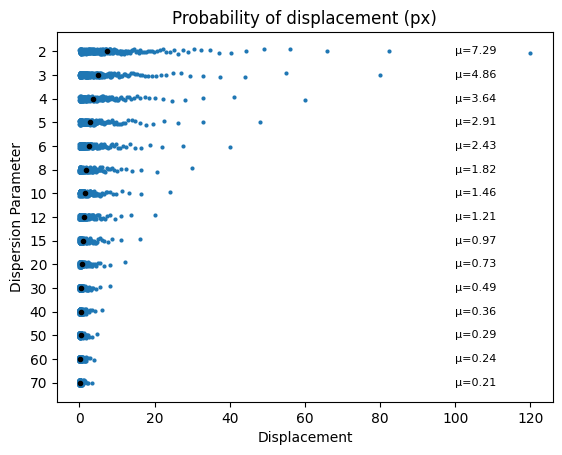

In [4]:
# Convert 'd' column to categorical data type
df['d'] = df['d'].astype('str')

# Create strip plot
ax = sns.stripplot(data=df, x='x', y='d', jitter=True, size=3)

# Add mean points
disps = df['d'].unique()  # Get unique categories in sorted order

for i, disp in enumerate(disps):
    # Calculate median and mean
    median_val = df[df['d'] == disp]['x'].median()
    mean_val = df[df['d'] == disp]['x'].mean()
    ax.plot(mean_val, i, 'o', color = "black", markersize=3, zorder=3)  # Plot mean point

    # Annotate the mean value using the μ symbol
    ax.text(mean_val + (100-mean_val), i, f'μ={mean_val:.2f}', verticalalignment='center', horizontalalignment='left', fontsize=8, color='black')

# Add titles and labels
plt.title('Probability of displacement (px)')
plt.xlabel('Displacement')
plt.ylabel('Dispersion Parameter')

# Show the plot
plt.show()

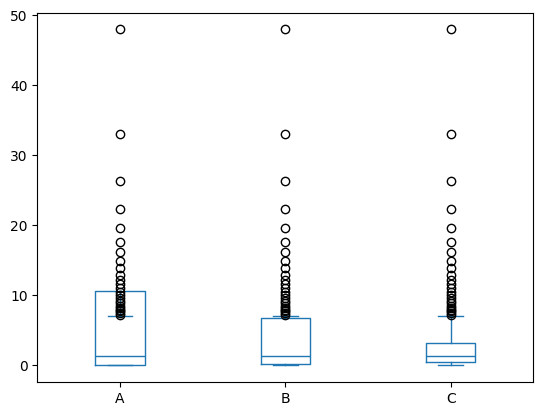

In [29]:
# d = [2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 30, 40, 50, 60, 70]


data = df[df['d'] == 5]
data = data['x'].tolist()

stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(data, labels='A')[0]
stats['B'] = cbook.boxplot_stats(data, labels='B')[0]
stats['C'] = cbook.boxplot_stats(data, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(data, [0, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(data, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(data, [25, 75])

fig, ax = plt.subplots(1, 1)
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3), flierprops = None)

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')


In [23]:
df_filtered = df[df['d'] == 5]
a_list = df_filtered['x'].tolist()


      d    b          x
768   5    0  48.000000
769   5    1  33.003867
770   5    2  26.360334
771   5    3  22.400000
772   5    4  19.697336
...  ..  ...        ...
1019  5  251   0.025297
1020  5  252   0.018916
1021  5  253   0.012574
1022  5  254   0.006268
1023  5  255   0.000000

[256 rows x 3 columns]
[48.0, 33.00386719675124, 26.36033378250884, 22.400000000000002, 19.697336089597847, 17.70231247174979, 16.151781018072434, 14.901933598375619, 13.866666666666667, 12.990861620062104, 12.237380842381498, 11.58016689125442, 11.000325023365868, 10.48377558591613, 10.019783155054649, 9.600000000000001, 9.217824001860249, 8.867955732250412, 8.546085574172762, 8.248668044798924, 7.972755980082809, 7.715876677407255, 7.475937999722229, 7.251156235874894, 7.040000000000001, 6.841146119075024, 6.653444594169613, 6.475890509036216, 6.307601314665056, 6.1477983147548345, 5.995791463770876, 5.850966799187809, 5.7127759849317306, 5.580727559296453, 5.454379568420009, 5.333333333333333, 5.217

### Heatmap

In [ ]:
#### HEATMAP 
# I'll filter out the table to only have d and x
df_small = df.drop('b', axis=1)

# Define bins for x
bins = range(0, 100, 10)  # Define your bins as needed

# Create a new column 'bin' with bins for x
df_small['bin'] = pd.cut(df_small['x'], bins)

# Group by 'd' and 'bin', then count the occurrences
matrix_long = df_small.groupby(['d', 'bin']).size().reset_index(name='count')

# Now I pivot so then it is easier to make a heatmap
matrix = matrix_long.pivot_table(index='d', columns='bin', values='count', fill_value=0)

To normalize the counts in each bin for each category (d) such that the values range from 0 to 1, I will divide each count in the matrix DataFrame by the sum of counts in its respective row ( d). This will scale the counts to represent proportions or probabilities.

In [ ]:
# normalize matrix by d
normalized_matrix = matrix.div(matrix.sum(axis=1), axis=0)

In [ ]:
# heatmap
plt.figure(figsize=(7, 4))
sns.heatmap(normalized_matrix, cmap='YlOrBr')
plt.title('Displacement (px)')
plt.xlabel('displacements bins')
plt.ylabel('Dispersion Parameter')
plt.show()
